In [5]:
# code here
import cv2
import matplotlib.pyplot as plt
import numpy as np

1) Aplique nas imagens abaixo o algortimo Watershed para realizar a contagem de células. Faça tanto para  a imagem original e para a imagem gradiente

In [89]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from copy import deepcopy

def component_labeling(img, black_value=0):
    lines, columns = img.shape
        
    modifiers = [(-1,0),(0,-1)] # The index of the neighborhood pixels that should be verified.
    
    labels = np.zeros((lines, columns))
    equivalences = defaultdict(set)
    labels_without_equivalences = set()
    
    next_label = 1
    for i in range(lines):
        for j in range(columns):
            if img[i][j] == black_value or img[i][j] == 2: # Black (ignore).
                continue 
            
            for (modifier_i, modifier_j) in modifiers:
                try:
                    neighbor_label = labels[i + modifier_i][j + modifier_j]
                    if neighbor_label != 0: # Labelled neighbor
                        if labels[i][j] == 0:
                            labels[i][j] = neighbor_label # Receives the first label found.
                        elif labels[i][j] == neighbor_label:
                            continue
                        else:
                            smaller = min(labels[i][j], neighbor_label)
                            bigger = max(labels[i][j], neighbor_label)
                                
                            equivalences[smaller].add(bigger)           
                except IndexError:
                    continue
                
            if labels[i][j] == 0: # The pixel hasn't been labelled.
                labels[i][j] = next_label # The next available label is assigned to it.
                labels_without_equivalences.add(next_label) # Faltou adicionar código pra retirar a label quando ela tiver equivalencia
                next_label += 1

    final_equivalences = resolve_transitive_equivalences(equivalences)
    for i in range(lines):
        for j in range(columns):
            label = labels[i][j]
            if label != 0:
                try:
                    labels[i][j] = final_equivalences[label]
                except KeyError:
                    continue
                
    return labels


def resolve_transitive_equivalences(equivalences):
    
    # Solve cases like 1 --> 2, 2 --> 3 (transitive)
    to_be_removed = []
    for key in list(equivalences.keys()):
        stack = list(equivalences[key])
            
        while len(stack) > 0:
            try:
                next = stack.pop(0)
                to_be_removed.append(next)
                next_values = list(equivalences[next])

                for item in next_values:
                    if item == key:
                        continue
                    
                    if item not in equivalences[key]:
                        stack.append(item)
                        equivalences[key].add(item)  
            except ValueError:
                continue
            
    for rem in to_be_removed:
        try:
            del equivalences[rem]
        except KeyError:
            continue
        
    # Solve cases like 1 --> 3, 2 --> 3 (common element)
    to_be_removed = []
    for key1 in list(equivalences.keys()):
        for key2 in list(equivalences.keys()):
            if key1 == key2:
                continue
            
            if equivalences[key1].isdisjoint(equivalences[key2]):
                continue
            
            # There is a common element
            
            smaller = min(key1, key2)
            bigger = max(key1, key2)
            
            equivalences[smaller].update(equivalences[bigger])
            equivalences[smaller].add(bigger)
            
            to_be_removed.append(bigger)
    
    for rem in to_be_removed:
        try:
            del equivalences[rem]
        except KeyError:
            continue        
                            
    final_equivalences = defaultdict()
    for key, values in equivalences.items():        
        for item in values:
            final_equivalences[item] = key
        
        final_equivalences[key] = key
            
    return final_equivalences

def re_sequence_labels(labelled_img):
    next_label = 1
    
    new_labels = defaultdict()
    
    lines, columns = labelled_img.shape
    for i in range(lines):
        for j in range(columns):
            actual_position = labelled_img[i][j] 
            if actual_position != 0:
                if actual_position not in new_labels:
                    new_labels[actual_position] = next_label
                    next_label += 1
                
                labelled_img[i][j] = new_labels[actual_position]
                
    return labelled_img, (next_label - 1)

# if __name__ == "__main__":
#     img = cv2.imread("art8.png", cv2.IMREAD_GRAYSCALE)

#     labelled_img = component_labeling(img)
#     re_labelled_img, num_components = re_sequence_labels(labelled_img)
    
#     print(f"Number of components: {num_components}")
    
#     plt.subplot(1,2,1)
#     plt.imshow(re_labelled_img, cmap='gray', vmin=0, vmax=num_components)
    
#     plt.subplot(1,2,2)
#     plt.imshow(re_labelled_img, cmap='hsv', vmin=0, vmax=num_components)

def reamostragem(img, old_dpi, new_dpi):
    """
        Realiza o processo de reamostragem da imagem passada, reamostrand de old_dpi para new_dpi.
        
        Args:
            img (np.ndarray): A imagem que será reamostrada.
            old_dpi (int): O dpi da imagem.
            new_dpi (int): O dpi desejado.
            
        Returns:
            Numpy.ndarray, representando a nova imagem.
    """
    
    altura = img.shape[0]
    largura = img.shape[1]
    
    proporcao = new_dpi / old_dpi # Proporção do dpi da nova imagem em relação à original.
    
    nova_altura = int(altura * proporcao) 
    nova_largura = int(largura * proporcao)
    #Tamanho da nova imagem
    
    pixels_por_pixel = altura / nova_altura 
    # Indica a quantidade de pixels da imagem antiga que devem ser condensados em um único pixel da nova imagem.
    # Valor serve tanto para altura como para largura

    nova_img = np.zeros((nova_altura, nova_largura))

    altura_atual = 0
    for i in range(0,nova_altura):
        largura_atual = 0
        for j in range(0, nova_largura):
            # (i,j) é o novo pixel
            
            altura_limite = int(altura_atual + pixels_por_pixel)
            largura_limite = int(largura_atual + pixels_por_pixel)
            
            buffer = np.sum(img[int(altura_atual):altura_limite, int(largura_atual):largura_limite])
            
            num_pixels = (altura_limite - int(altura_atual)) * (largura_limite - int(largura_atual))
            nova_img[i,j] = int( buffer // num_pixels)
            
            largura_atual += pixels_por_pixel
        altura_atual += pixels_por_pixel
        
    return nova_img


(283, 637) 1


AttributeError: 'list' object has no attribute 'add'

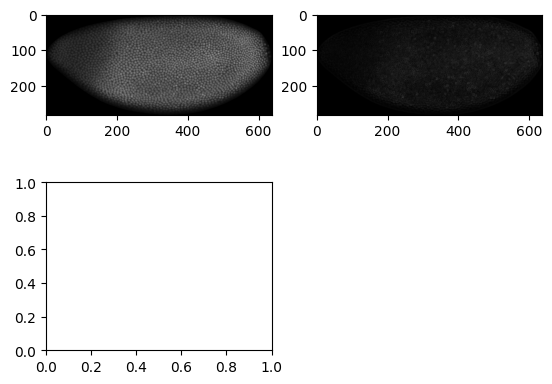

In [93]:
def dilatacao(A, B):
    # B é o elemento estruturante
    A = list(A)
    B = list(B)
    di = set()
    
    for i,j in A:
        for h,k in B:
            di.add((i+h,j+k))
            
    return di

def watershed(img):
    lines, columns = img.shape
    
    img = 255 - img
    
    minimo = int(np.min(img))
    maximo = int(np.max(img))
    
    T = np.zeros(img.shape)
    for i in range(lines):
        for j in range(columns):
            if int(img[i,j]) < minimo + 1:
                T[i,j] = 1 # T[min + 1]

    labelled_img = component_labeling(T)
    C_labels, _ = re_sequence_labels(labelled_img) # Labels de 1 até num_components
    C = defaultdict(set)
    for i in range(lines):
        for j in range(columns):
            if C_labels[i,j] != 0:
                C[C_labels[i,j]].add((i,j))        
    # Cria os componentes de C[min +  1]. Uso de componentes conexos para considerar pixels adjacentes como uma basin.   
    C_list = list(C.values())
    
    for n in range(minimo + 2, maximo + 2):        
        count = 0
        for i in range(lines):
            for j in range(columns):
                if T[i,j] == 2:
                    continue #Barreira
                
                if int(img[i,j]) < n:
                    T[i,j] = 1 # T[n]
                    count += 1 
        
        print(img.shape, count)
                    
        labelled_img = component_labeling(T)
        Q, num_components = re_sequence_labels(labelled_img) # Labels de 1 até num_components
        
        Q_components = defaultdict(set)
        for i in range(lines):
            for j in range(columns):
                if Q[i,j] != 0:
                    Q_components[Q[i,j]].add((i,j))
                                        
                # Cria os conjuntos de pontos para cada componente conexo
                     
        C_next = []
        to_remove = []
        for _, q_value in Q_components.items():
            original = []
            for value in C_list:
                if q_value.isdisjoint(value): #interseção vazia
                    continue
                
                original.append(value)
                    
            if len(original) == 0:
                C_next.append(q_value)
            elif len(original) == 1:
                C_next.append(original[0] | q_value) # Append a união de q com o component conexo
                to_remove.append(original[0])
            else:
                elemento_estruturante = [(0,0),(0,1),(0,2),(1,0),(1,1),(1,2),(2,0),(2,1),(2,2)]
                
                result = dilatacao(original[0] | original[1] | q_value, elemento_estruturante)
                dil_em_q = result & q_value # Coordenadas dos pontos da dilatação que fazem parte apenas de 'q'
                
                for i,j in dil_em_q:
                    T[i,j] = 2 # A barreira é erguida
               
        for re in to_remove:
            C_list.remove(re)
            
        for ad in C_next:
            C_list.append(ad)       
        
        print(len(C_list))

    return T

def convert(img):
    lin, col = img.shape
    
    for i in range(lin):
        for j in range(col):
            if img[i,j] == 1:
                img[i,j] = 128
            elif img[i,j] == 2:
                img[i,j] = 255        
    
    return img
    
img1 = cv2.imread("image.jpg", cv2.IMREAD_GRAYSCALE)
img1 = reamostragem(img1, 250, 125)

# Aplicar um filtro gaussiano para suavizar a imagem
blurred = cv2.GaussianBlur(img1, (5, 5), 0)

# Calcular o gradiente da imagem
gradient = cv2.morphologyEx(blurred, cv2.MORPH_GRADIENT, np.ones((3, 3), np.uint8))

plt.subplot(2,2,1)
plt.imshow(img1, cmap='gray', vmin=0, vmax=255)
plt.subplot(2,2,2)
plt.imshow(gradient, cmap='gray', vmin=0, vmax=255)
plt.subplot(2,2,3)
plt.imshow(convert(watershed(img1)), cmap='gray', vmin=0, vmax=255)
plt.subplot(2,2,3)
plt.imshow(convert(watershed(gradient)), cmap='gray', vmin=0, vmax=255);


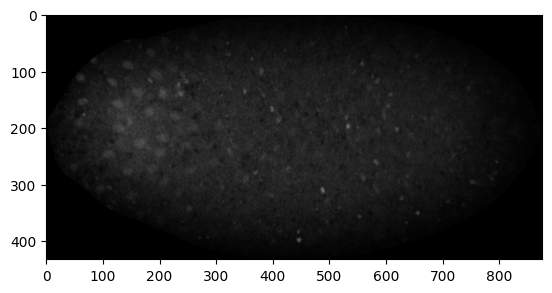

In [18]:
img2 = cv2.imread("image2.jpg", cv2.IMREAD_GRAYSCALE)

plt.imshow(img2, cmap='gray', vmin=0, vmax=255);

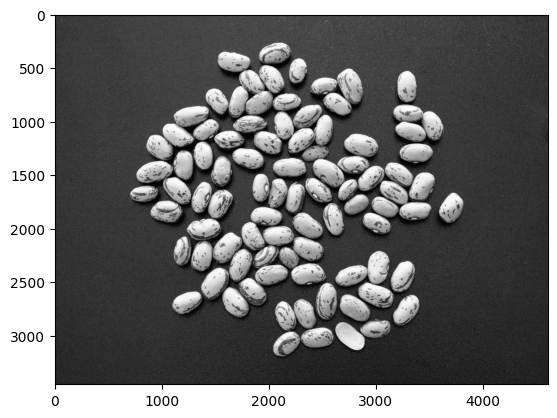

In [19]:
img3 = cv2.imread("feijao.jpg", cv2.IMREAD_GRAYSCALE)

plt.imshow(img3, cmap='gray', vmin=0, vmax=255);